In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA
import pandas as pd
import torch
from plotting_utils import interleave_scatter
from fca.projections import explained_variance 
from divergence_utils import visualize_states

In [2]:
data_path = "data/attn_head_activations.pt"
data = torch.load(data_path)
data.keys()

dict_keys(['p1_hidden_states', 'p2_hidden_states', 'p1_patched_hidden_states', 'copy_indices'])

In [3]:
base_hstates = data["p1_hidden_states"]
base2_hstates = data["p2_hidden_states"]
intrv_hstates = data["p1_patched_hidden_states"]

In [4]:
intrv_hstates.shape

torch.Size([800, 14, 29, 4096])

In [5]:
positions = []
layers = []
for samp in range(len(intrv_hstates)):
    for layer in range(intrv_hstates.shape[1]):
        do_break = False
        for pos in range(intrv_hstates[samp][layer].shape[0]):
            if not torch.all( intrv_hstates[samp][layer][pos] == base_hstates[samp][layer][pos] ):
                layers.append(layer)
                positions.append(pos)
                do_break = True
                break
        if do_break: break
positions = torch.LongTensor(positions)
layers = torch.LongTensor(layers)
og_layer = layers[1]

In [6]:
assert torch.all(positions==torch.LongTensor(data["copy_indices"]))

In [7]:
assert torch.all((layers[1:]-layers[:-1])==0)

In [8]:
print("Layer:", og_layer)
print("Position:", pos)

Layer: tensor(1)
Position: 14



Layer: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_vecs = torch.tensor(vecs[:len(natty_states)])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intrv_vecs = torch.tensor(vecs[len(natty_states):])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float()
/home/grantsrb/src/pyvene_fork/divergenc

Top Expl Vars: tensor([0.1501, 0.0888, 0.0603, 0.0545, 0.0483])
Vis Expl Vars: tensor(0.0329) tensor(0.0011)


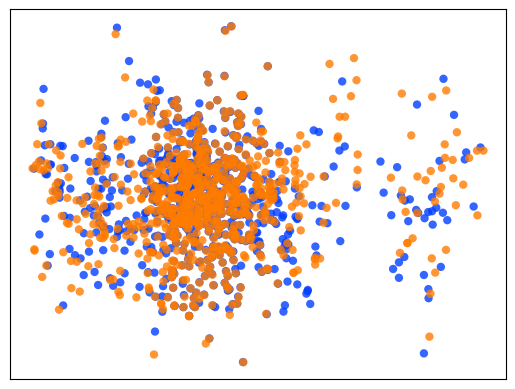

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_vecs = torch.tensor(vecs[:len(natty_states)])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intrv_vecs = torch.tensor(vecs[len(natty_states):])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float()


base_emd    1809.106104
emd         3536.148168
dtype: float64

In [12]:
n_samples = 10
pos = None
layer = None
pos_offset = 0

rows = torch.arange(len(base_hstates)).long()
if layer is not None:
    layers[:] = layer
else:
    layers[:] = og_layer
    
d = intrv_hstates.shape[-1]
natty_states = base_hstates[rows,layers,positions+pos_offset].reshape(-1,d)
intrv_states = intrv_hstates[rows,layers,positions+pos_offset].reshape(-1,d)

print()
print("Layer:", layer)
print("Natty:", natty_states.shape)
print("Intrv:", intrv_states.shape)
emd_df_dict = {
    "sample_id": [],
    "mse": [],
    "emd": [],
    "base_emd": [],
}
for samp_id in range(n_samples):
    diffs = visualize_states(
        natty_states,
        intrv_states,
        xdim=None,
        ydim=None,
        incl_legend=False,
        save_name="figs/single_attn_head.png",
        emd_sample_type="permute",
        emd_sample_size=len(natty_states)//2,
        normalize_emd=True,
        visualize=samp_id==0,
    )
    mse = diffs["mse"]
    emd = diffs["emd"]
    base_emd = diffs["base_emd"]
    emd_df_dict["sample_id"].append(samp_id)
    emd_df_dict["emd"].append(emd)
    emd_df_dict["base_emd"].append(base_emd)
    emd_df_dict["mse"].append(mse)
emd_df = pd.DataFrame(emd_df_dict)
emd_df[["base_emd","emd",]].mean()
    

In [ ]:
d = dict(emd_df[["base_emd","emd",]].mean())
base_emd = d["base_emd"]
emd = d["emd"]
perc = (emd-base_emd)/base_emd
frac = emd/base_emd
print("EMD %:", perc)
print("EMD Frac:", frac)

In [13]:
emd_df["method"] = "indy attn patch"
if not os.path.exists("csvs/"):
    os.mkdir("csvs/")
emd_df.to_csv("csvs/indy_attn_patch_emd.csv", header=True, index=False)